In [1]:
import nibabel as nib
import nilearn as nil
import numpy as np
import pandas as pd
import os
import os.path
from nilearn import plotting, image
from nipype.interfaces.spm import TwoSampleTTestDesign, EstimateModel, EstimateContrast, Threshold, MultipleRegressionDesign
from nipype.pipeline.engine import Workflow, Node, MapNode
import sys
sys.path.append('..')
from src.utils.data import getDataPandas, getPandas, getConfig
os.chdir('..')

In [4]:
hc = getPandas('hc_data')
age_list = hc['AGE'].tolist()
img_list = hc['CAT12_GM']
img_list = img_list.apply(os.path.abspath).tolist()

In [30]:
wf = Workflow(name='agecorrection', base_dir='tmp')

mr = Node(MultipleRegressionDesign(), name='mr')
mr.inputs.in_files = img_list
mr.inputs.include_intercept = True
mr.inputs.user_covariates = [
    {'name': 'age', 'vector': age_list}
]

model = Node(EstimateModel(), name='model')
model.inputs.estimation_method = {'Classical': 1}
#model.inputs.use_implicit_threshold = True

contrast = Node(EstimateContrast(), name='contrast')
con = ('age','T', ['age'],[1])
contrast.inputs.contrasts = [con]
contrast.inputs.group_contrast = True

threshold = Node(Threshold(
    contrast_index=1,
    use_topo_fdr=True,
    use_fwe_correction=False,
    extent_threshold=0,
    height_threshold=0.05,
    height_threshold_type='p-value',
    extent_fdr_p_threshold=0.05), name='thres')

wf.connect([
    (mr, model, [('spm_mat_file', 'spm_mat_file')]),
    (model, contrast, [('spm_mat_file', 'spm_mat_file'),
                        ('beta_images', 'beta_images'),
                        ('residual_image', 'residual_image')]),
    (contrast, threshold, [('spm_mat_file', 'spm_mat_file'),
                            ('spmT_images', 'stat_image')]),
])

wf.run()

230407-21:44:54,590 nipype.workflow INFO:
	 Workflow agecorrection settings: ['check', 'execution', 'logging', 'monitoring']
230407-21:44:54,601 nipype.workflow INFO:
	 Running serially.
230407-21:44:54,601 nipype.workflow INFO:
	 [Node] Setting-up "agecorrection.mr" in "/home/biobot/disk/ldopa/tmp/agecorrection/mr".
230407-21:44:54,608 nipype.workflow INFO:
	 [Node] Cached "agecorrection.mr" - collecting precomputed outputs
230407-21:44:54,609 nipype.workflow INFO:
	 [Node] "agecorrection.mr" found cached.
230407-21:44:54,609 nipype.workflow INFO:
	 [Node] Setting-up "agecorrection.model" in "/home/biobot/disk/ldopa/tmp/agecorrection/model".
230407-21:44:54,612 nipype.workflow INFO:
	 [Node] Cached "agecorrection.model" - collecting precomputed outputs
230407-21:44:54,612 nipype.workflow INFO:
	 [Node] "agecorrection.model" found cached.
230407-21:44:54,613 nipype.workflow INFO:
	 [Node] Setting-up "agecorrection.contrast" in "/home/biobot/disk/ldopa/tmp/agecorrection/contrast".
23040

/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


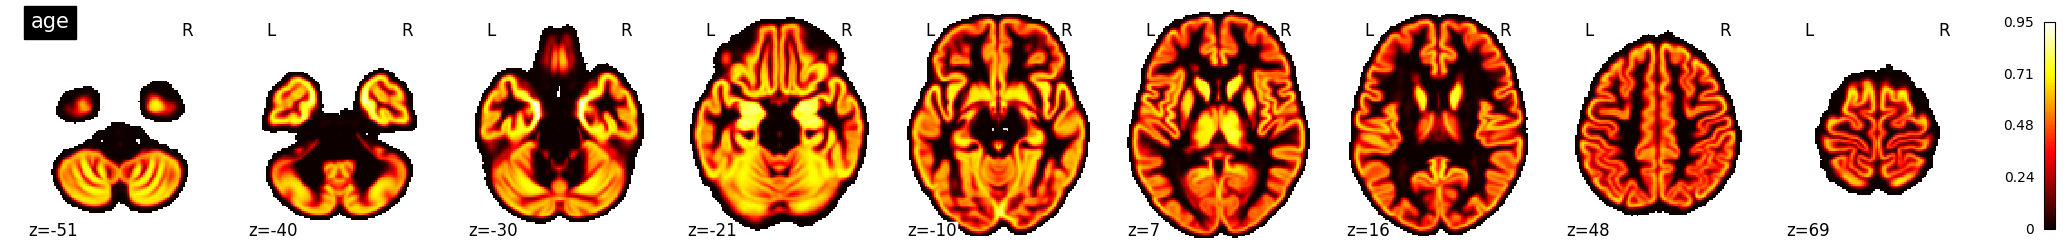

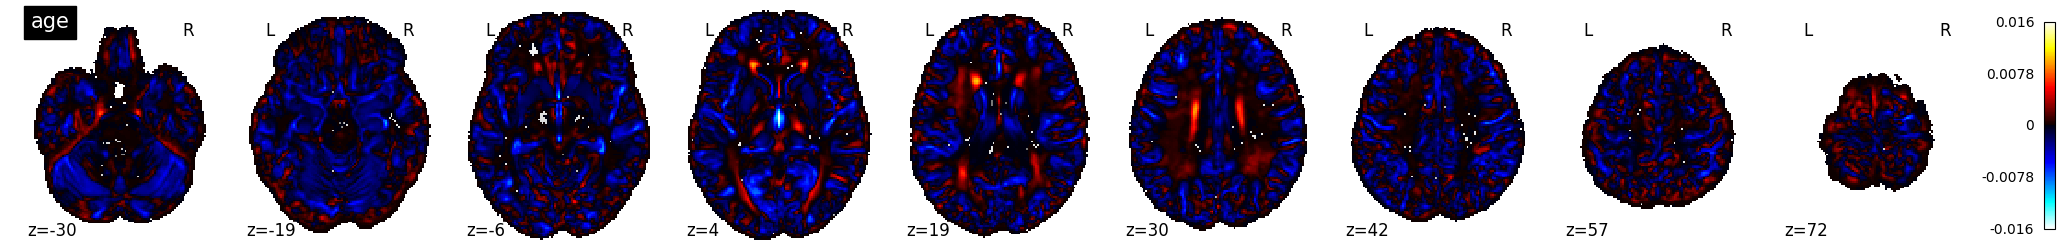

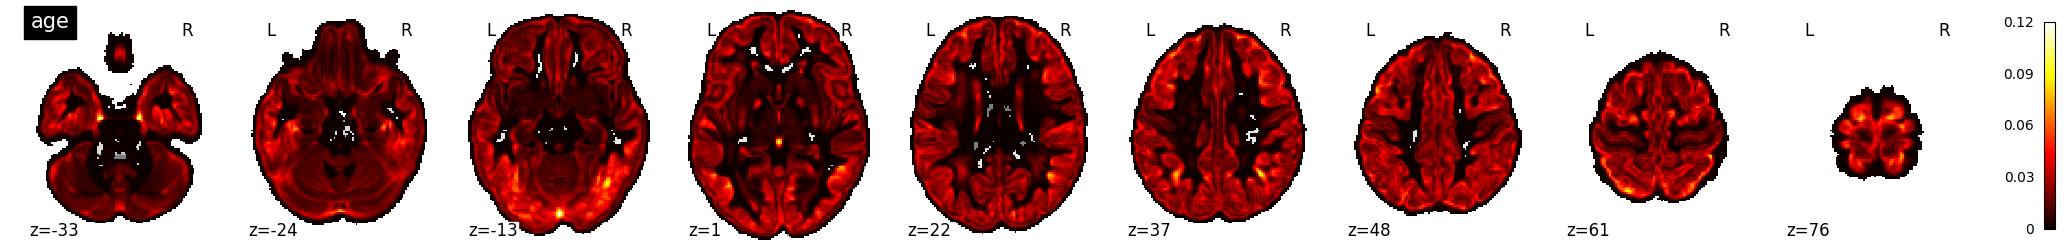

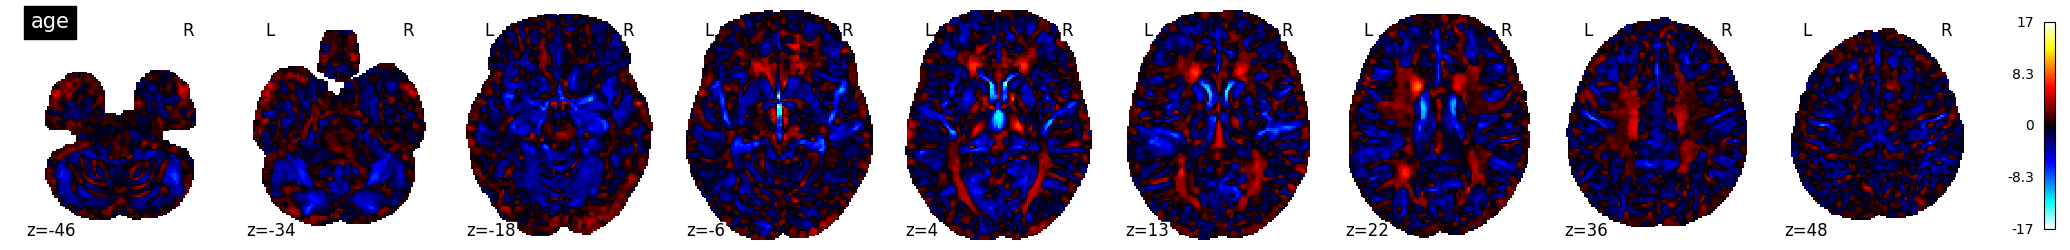

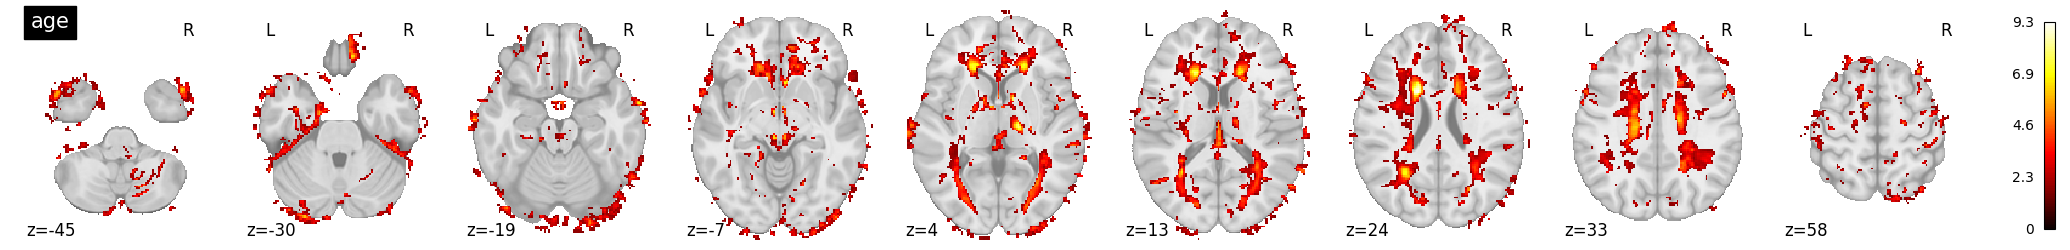

In [29]:
from nilearn import plotting, image
import matplotlib.pyplot as plt
plotting.plot_stat_map('tmp/agecorrection/model/beta_0001.nii', display_mode='z', cut_coords=9, title='age')
plt.show()
plotting.plot_stat_map('tmp/agecorrection/model/beta_0002.nii', display_mode='z', cut_coords=9, title='age')
plt.show()
plotting.plot_stat_map('tmp/agecorrection/model/ResMS.nii', display_mode='z', cut_coords=9, title='age')
plt.show()
plotting.plot_stat_map('tmp/agecorrection/contrast/spmT_0001.nii', display_mode='z', cut_coords=9, title='age')
plt.show()
plotting.plot_stat_map('tmp/agecorrection/thres/spmT_0001_thr.nii', display_mode='z', cut_coords=9, title='age')
plt.show()

In [3]:
data = getPandas('pat_data')
data_config = getConfig('data')
train_inds = data_config['indices']['train']
test_inds = data_config['indices']['test']
data_train = data.iloc[train_inds].reset_index(drop=True)
data_test = data.iloc[test_inds].reset_index(drop=True)
data_full = data.iloc[train_inds + test_inds].reset_index(drop=True)

In [4]:
train_good = data_train[data_train['CAT_MDS']==1]
train_bad = data_train[data_train['CAT_MDS']==0]
#train_good = data_full[data_full['CAT']==1]
#train_bad = data_full[data_full['CAT']==0]
img_good = train_good['FSL_SGM']
img_bad = train_bad['FSL_SGM']
img_good = img_good.apply(os.path.abspath)
img_bad = img_bad.apply(os.path.abspath)

In [5]:
age_good = train_good['AGE']
age_bad = train_bad['AGE']
sex_good = train_good['SEX']
sex_bad = train_bad['SEX']
agelist = age_good.tolist() + age_bad.tolist()
sexlist = sex_good.tolist() + sex_bad.tolist()

In [8]:
wf = Workflow(name='voxelwise', base_dir='tmp')

ttest = Node(TwoSampleTTestDesign(), name='ttest')
ttest.inputs.group1_files = img_good.tolist()
ttest.inputs.group2_files = img_bad.tolist()
ttest.inputs.covariates = [
    {'name': 'age', 'vector': agelist},
    {'name': 'sex', 'vector': sexlist},
]

model = Node(EstimateModel(), name='model')
model.inputs.estimation_method = {'Classical': 1}

contrast = Node(EstimateContrast(), name='contrast')
con1 = ('good>bad','T', ['Group_{1}','Group_{2}'],[1,-1])
con2 = ('bad>good','T', ['Group_{1}','Group_{2}'],[-1,1])
con_list = [con1, con2]
contrast.inputs.contrasts = con_list
contrast.inputs.group_contrast = True

threshold = MapNode(Threshold(
    contrast_index=1,
    use_topo_fdr=True,
    use_fwe_correction=False,
    extent_threshold=0,
    height_threshold=0.05,
    height_threshold_type='p-value',
    extent_fdr_p_threshold=0.05), name='thres', iterfield=['stat_image'])

wf.connect([
    (ttest, model, [('spm_mat_file', 'spm_mat_file')]),
    (model, contrast, [('spm_mat_file', 'spm_mat_file'), ('beta_images', 'beta_images'), ('residual_image', 'residual_image')]),
    (contrast, threshold, [('spm_mat_file', 'spm_mat_file'), ('spmT_images', 'stat_image')])
])

wf.run()

230407-10:23:56,18 nipype.workflow INFO:
	 Workflow voxelwise settings: ['check', 'execution', 'logging', 'monitoring']
230407-10:23:56,32 nipype.workflow INFO:
	 Running serially.
230407-10:23:56,33 nipype.workflow INFO:
	 [Node] Setting-up "voxelwise.ttest" in "/home/biobot/disk/ldopa/tmp/voxelwise/ttest".
230407-10:23:56,41 nipype.workflow INFO:
	 [Node] Cached "voxelwise.ttest" - collecting precomputed outputs
230407-10:23:56,41 nipype.workflow INFO:
	 [Node] "voxelwise.ttest" found cached.
230407-10:23:56,42 nipype.workflow INFO:
	 [Node] Setting-up "voxelwise.model" in "/home/biobot/disk/ldopa/tmp/voxelwise/model".
230407-10:23:56,44 nipype.workflow INFO:
	 [Node] Cached "voxelwise.model" - collecting precomputed outputs
230407-10:23:56,44 nipype.workflow INFO:
	 [Node] "voxelwise.model" found cached.
230407-10:23:56,44 nipype.workflow INFO:
	 [Node] Setting-up "voxelwise.contrast" in "/home/biobot/disk/ldopa/tmp/voxelwise/contrast".
230407-10:23:56,47 nipype.workflow INFO:
	 [No

stty: 标准输入: 对设备不适当的 ioctl 操作


230407-10:24:11,49 nipype.workflow INFO:
	 [Node] Finished "_thres1", elapsed time 7.456399s.


stty: 标准输入: 对设备不适当的 ioctl 操作
